For my [day job](https://monetate.com), I spend a lot of time thinking about e-commerce analytics and [cohort analysis](https://en.wikipedia.org/wiki/Cohort_analysis) in particular.  Statistical [age-period-cohort](https://www.publichealth.columbia.edu/research/population-health-methods/age-period-cohort-analysis) (APC) models are important in many fields such as epidemiology, demography, marketing, and many more.  These models also pose some interesting inferential challenges for the unwary.  This post shows how to use [`pymc`](https://www.pymc.io/welcome.html) to build Bayesian APC models in Python and presents a series of increasingly sophistocated systems of priors to resolve the inferential challenges these models pose.

First we make the necessary Python imports and do some light housekeeping.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
from warnings import filterwarnings

In [3]:
from aesara import tensor as at
import arviz as az
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import seaborn as sns

In [4]:
filterwarnings("ignore", category=UserWarning, module="pymc")

In [5]:
plt.rc("figure", figsize=(8, 6))
sns.set(color_codes=True)

## Load the data

For illustrative purposes, we use data from the [US General Social Survey 1974-2002](https://vincentarelbundock.github.io/Rdatasets/doc/AER/GSS7402.html) in this post.  This dataset is available from Vincent Arel-Bundock's excellent [`Rdatasets`](https://vincentarelbundock.github.io/Rdatasets/index.html) repository and is originally from the [AER (Applied Econometrics with R)](https://cran.r-project.org/web/packages/AER/index.html) R package.

In [6]:
DATA_URL = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/GSS7402.csv"

In [7]:
df = (pd.read_csv(DATA_URL, usecols=["kids", "age", "year"])
        [["age", "year", "kids"]])

In [8]:
df

,age,year,kids
0,25,2002,0
1,30,2002,1
2,55,2002,1
3,57,2002,2
4,71,2002,2
...,...,...,...
9115,30,1998,3
9116,37,1998,2
9117,59,1998,3
9118,73,1998,2


## Exploratory data analysis

From the [`Rdatasets` site](https://vincentarelbundock.github.io/Rdatasets/doc/AER/GSS7402.html), this data set contains

> [c]ross-section data for 9120 women taken from every fourth year of the US General Social Survey between 1974 and 2002 to investigate the determinants of fertility.

The columns of this data frame are

* `age`: the age at which the woman was surveyed,
* `year`: the year the woman was surveyed, and
* `kids`: the number of children the woman had at the time she was surveyed.

These columns contain all the information we need to build an APC model of how the average number of children has varied as a function of the woman's age, the year, and when she was born.  Obviously the `age` column corresponds to the "age" component of the APC model, and the `year` column corresponds to the "period" component of the APC model.  For this data set, the "cohort" component corresponds to they year in which the woman was born, which is simply calculated as the difference between the woman's age and the current year.

In [9]:
df["cohort"] = df["year"] - df["age"]

In [10]:
df

,age,year,kids,cohort
0,25,2002,0,1977
1,30,2002,1,1972
2,55,2002,1,1947
3,57,2002,2,1945
4,71,2002,2,1931
...,...,...,...,...
9115,30,1998,3,1968
9116,37,1998,2,1961
9117,59,1998,3,1939
9118,73,1998,2,1925


It is this relationship between `age`, `year`, and `cohort` that will make a naively parametrized APC model [unidentified](https://en.wikipedia.org/wiki/Identifiability), causing inferential challenges.

The following plots show how the average number of childen women varies with age, period (year), and cohort.

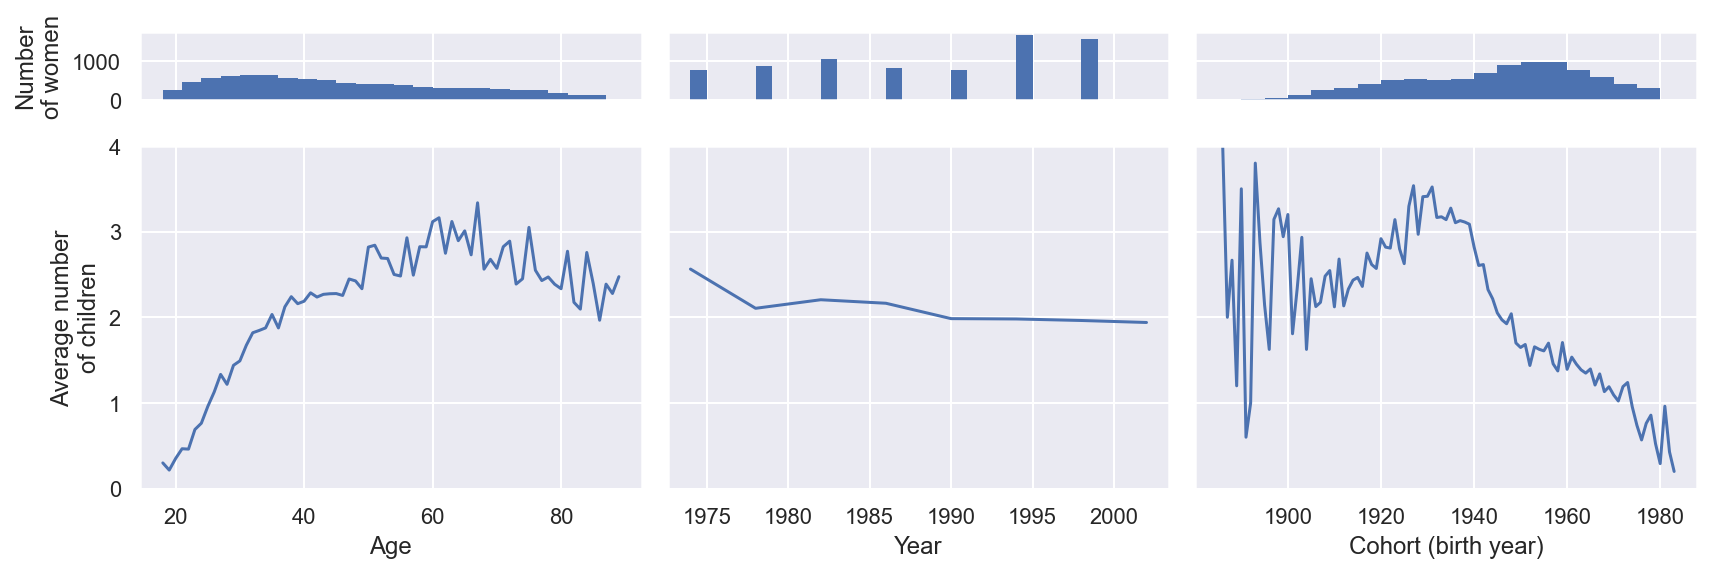

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 4),
                         gridspec_kw={"height_ratios": (1, 5)})

axes[0, 0].sharex(axes[1, 0]);
axes[0, 1].sharex(axes[1, 1]);
axes[0, 2].sharex(axes[1, 2]);

axes[0, 0].sharey(axes[0, 1]);
axes[0, 1].sharey(axes[0, 2]);

axes[1, 0].sharey(axes[1, 1]);
axes[1, 1].sharey(axes[1, 2]);

# age

axes[0, 0].hist(
    df["age"],
    bins=np.arange(df["age"].min(), df["age"].max() - 1, 3),
    lw=0
);

axes[0, 0].set_ylabel("Number\nof women");

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 0]));

axes[1, 0].set_xlabel("Age");
axes[1, 0].set_ylabel("Average number\nof children");

# year

axes[0, 1].hist(
    df["year"],
    bins=np.arange(df["year"].min(), df["year"].max() - 1),
    lw=0
);

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 1]));

axes[1, 1].set_xlabel("Year");

# cohort

axes[0, 2].hist(
    df["cohort"],
    bins=np.arange(df["cohort"].min(), df["cohort"].max() - 1, 5),
    lw=0
);

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(ax=axes[1, 2]));

axes[1, 2].set_xlabel("Cohort (birth year)");
axes[1, 2].set_ylim(0, 4);

fig.tight_layout();

The relationship with age is not surprising: throughout the twenties and thirties the average number of children increases at a relatively stable rate and then levels out from the forties onward.  The most notable feature of the period relationship is that it is relatively small compared to the age and cohort relationship.  The relationship with cohort is perhaps the most interesting.  The year a woman is born determines when she enters the prime chilbearing years of twenty to forty, so the peaks and troughs in the cohort relationship roughly corresponding to economic and societal conditions when the women in that cohort  are in prime childbearing years.

In [12]:
GREAT_DEPRESSION = np.array([1929, 1939])
BABY_BOOM = np.array([1946, 1964])

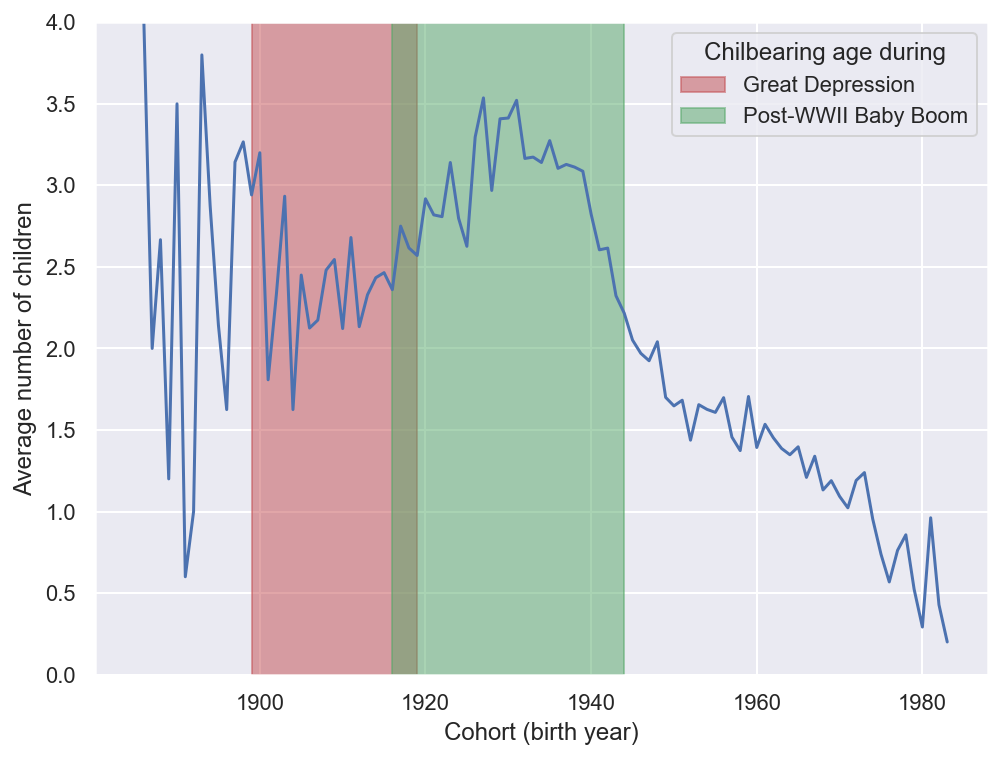

In [13]:
fig, ax = plt.subplots()

ax.axvspan(GREAT_DEPRESSION[0] - 30, GREAT_DEPRESSION[1] - 20,
           color="C3", alpha=0.5, label="Great Depression");
ax.axvspan(BABY_BOOM[0] - 30, BABY_BOOM[1] - 20,
           color="C2", alpha=0.5, label="Post-WWII Baby Boom");

(df.groupby("cohort")
   ["kids"]
   .mean()
   .plot(label="_nolegend_", ax=ax));

ax.set_xlabel("Cohort (birth year)");

ax.set_ylim(0, 4);
ax.set_ylabel("Average number of children");

ax.legend(loc="upper right", title="Chilbearing age during");

Taking a closer look at the cohort relationship, we see that the first trough corresponds to women that would be having most of their children during the [Great Depression](https://en.wikipedia.org/wiki/Great_Depression), and the subsequent peak corresponds to women having children during the post-World War II [baby boom](https://en.wikipedia.org/wiki/Baby_boom#United_States).

Taken together, it is reasonable to hypothesize that biological factors related to age and socioeconomic factors related to cohort are sufficient to explain the variation in the number of children without considering period (year).  The APC models we build in this post will allow us to evaluate the credibility of this hypothesis.

It is important to note at this point that I am not a demographer and even if I was, it is best not to draw deep demographic conclusions from any analysis conducted on this data set.  The purpose of this post is to use this data set as a simple example to illustrate some of the subtleties involved in inference using APC models.

### Dispersion

Since the number of children is discrete, we being by checking its [index of dispersion](https://en.wikipedia.org/wiki/Index_of_dispersion) in order to determine which probability distribution is best suited to model it.

In [14]:
def index_of_dispersion(x):
    return x.var() / x.mean()

In [15]:
index_of_dispersion(df["kids"])

1.5694754102397794

We see that the number of children is overdispersed across all responses.

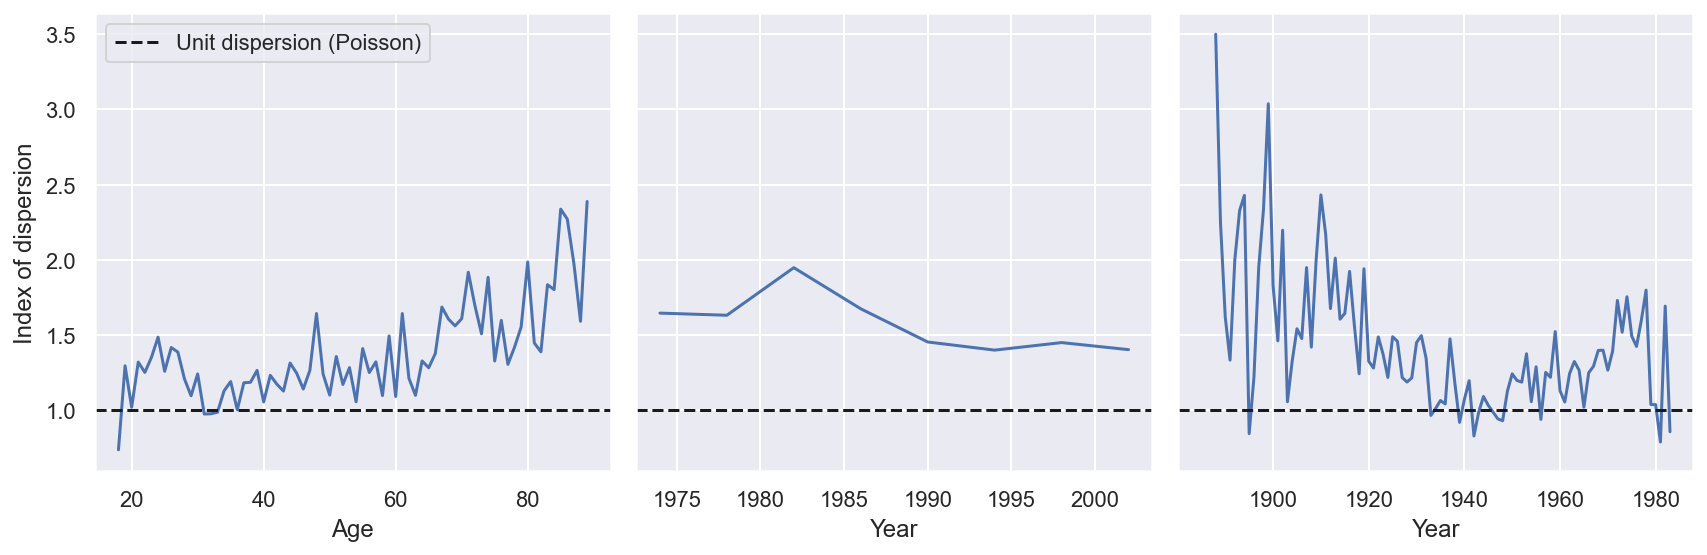

In [16]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

index_of_dispersion(df.groupby("age")["kids"]).plot(label="_nolegend_", ax=axes[0]);
axes[0].axhline(1, c="k", ls="--", label="Unit dispersion (Poisson)");

axes[0].set_xlabel("Age");
axes[0].set_ylabel("Index of dispersion");
axes[0].legend(loc="upper left");

index_of_dispersion(df.groupby("year")["kids"]).plot(ax=axes[1]);
axes[1].axhline(1, c="k", ls="--");

axes[1].set_xlabel("Year");

index_of_dispersion(df.groupby("cohort")["kids"]).plot(ax=axes[2]);
axes[2].axhline(1, c="k", ls="--");

axes[2].set_xlabel("Year");

fig.tight_layout();

The number of children continues to be overdispersed (without about the same index) across each of the APC dimensions, so we will use the overdispersed [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) in our models.

## Modeling

We now start to build APC models of the number of children reported.  [Recall](https://en.wikipedia.org/wiki/Negative_binomial_distribution#Distribution_of_a_sum_of_geometrically_distributed_random_variables) that if $X \sim \operatorname{NB}(\mu_X, \nu)$ and $Y \sim \operatorname{NB}(\mu_Y, \nu)$ then $X + Y \sim \operatorname{NB}(\mu_X + \mu_Y, \nu).$  Using this fact, we reduce the size of the observed data in our model by grouping by the age/period/cohort combination of each observation, counting the number of women with that combination, and summing their number of children.

In [17]:
apc_df = (df.groupby(["age", "year", "cohort"])
            ["kids"]
            .agg(("size", "sum")))

In [18]:
apc_df

size  sum
age year cohort           
18  1974 1956       3    2
    1978 1960       7    3
    1982 1964       2    0
    1986 1968       1    0
    1990 1972       2    0
...               ...  ...
89  1986 1897       5   10
    1990 1901       8   11
    1994 1905      14   35
    1998 1909      10   31
    2002 1913       9   11

[571 rows x 2 columns]

In [19]:
N = apc_df["size"].values
kids = apc_df["sum"].values

Here `apc_df["size"]` and `N` are the number of women surveyed at that specific age/period/cohort combination and `apc_df["sum"]` and `kids` are their total number of children.

For convenience we encode `age`, `year`, and `cohort` as ordinal factors.

In [20]:
i, age_map = apc_df.index.get_level_values("age").factorize(sort=True)
j, year_map = apc_df.index.get_level_values("year").factorize(sort=True)
k, cohort_map = apc_df.index.get_level_values("cohort").factorize(sort=True)

### Flat priors

We are now ready to build our first APC model, which will use [flat priors](https://en.wikipedia.org/wiki/Prior_probability#Uninformative_priors) for the age, period, and cohort effects.  Throughout this post, let $i$ denote a sample's age, $j$ denote its period, and $k$ denote its cohort.  All of our models will take the form

$$\begin{align*}
\eta_{ijk}
    & = \eta_0 + \alpha_i + \beta_j + \gamma_k, \\
y_{ijk}
    & \sim \operatorname{NB}(N_{ijk} \cdot \exp(\eta_{ijk}), \nu).
\end{align*}$$

Here $N_{ijk}$ is the number of women in the relevant age/period/cohort combination, $y_{ijk}$ is the total number of children they have, and $\nu$ controls the amount of overdispersion.  Note that this is a negative binomial regression model with an [offset](https://en.wikipedia.org/wiki/Poisson_regression#%22Exposure%22_and_offset) term.

Using `pymc` we specify the flat prior distributions

$$\pi(\eta_0), \pi(\alpha_i), \pi(\beta_i), \pi(\gamma_i) \propto 1.$$

In [21]:
coords = {
    "age": age_map,
    "year": year_map,
    "cohort": cohort_map
}

In [22]:
SEED = 1234567890 # for reproducibility

In [23]:
with pm.Model(coords=coords, rng_seeder=SEED) as flat_model:
    η0 = pm.Flat("η0")
    α = pm.Flat("α", dims="age")
    β = pm.Flat("β", dims="year")
    γ = pm.Flat("γ", dims="cohort")

Using the prior $\nu \sim \operatorname{Half-}N(2.5^2)$, we specify $\eta_{ijk}$ and the observational likelihood as above.

In [24]:
with flat_model:
    η = η0 + α[i] + β[j] + γ[k]
    
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N * at.exp(η), ν, observed=kids)

We are now ready to sample from the posterior distribution of this model.

In [25]:
CHAINS = 6

SAMPLE_KWARGS = {
    "cores": CHAINS,
    "random_seed": [SEED + i for i in range(CHAINS)]
}

In [26]:
with flat_model:
    flat_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, α, β, γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 428 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.3571, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.1821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9528, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached

We see quite a few warnings as a result of sampling, most notably over half of the post-tuning samples resulted in divergences, and the $\hat{R}$ statistics are well above the acceptable diagnostic threshold of 1.01.  For simplicty, we focus on the $\hat{R}$ statistics.

In [27]:
flat_rhat = az.rhat(flat_trace)

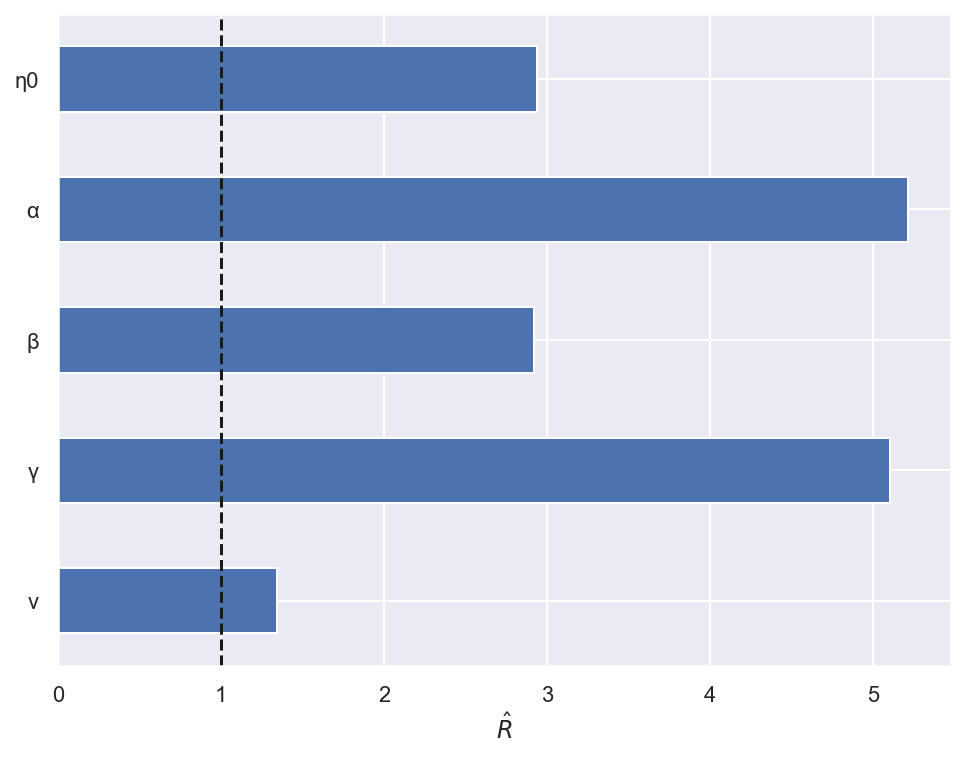

In [28]:
ax = (flat_rhat.max()
               .to_array()
               .to_series()
               .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

We see that all of the parameters have $\hat{R}$ statistics significantly above one (two are above five) that are indicative of severe problems with inference.  Focusing on the component of $\alpha$ with the highest $\hat{R}$ statistic we see that the chains are not very well mixed; they have explored completely different portions of the parameter space.

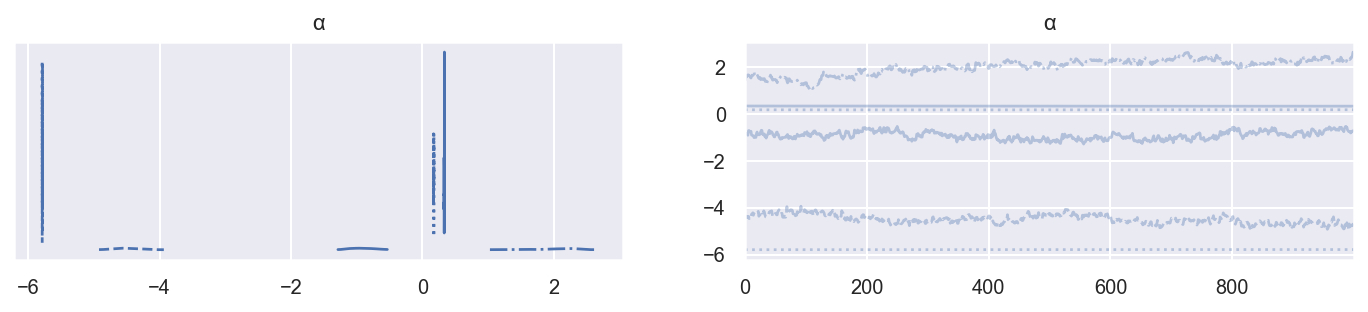

In [29]:
α_worst = flat_rhat["α"].idxmax()

az.plot_trace(flat_trace, var_names="α", coords={"age": α_worst}, divergences=False);

To quote the [folk theorem of statistical computing](https://statmodeling.stat.columbia.edu/2008/05/13/the_folk_theore/):

> When you have computational problems, often there’s a problem with your model.

With this wisdom in mind, experience indicates that this behavior in the sampler often arises when our model is [not identified](https://en.wikipedia.org/wiki/Identifiability), so it is time to return to our observation above that the relationship between `age`, `year`, and `cohort` would lead to inference problems.

### Lack of identification

Briefly, a model is not identified if two different sets of parameters lead to the same (log) likelihood of the observed data.  To illustrate the fact that this flat model is not identified, first we evaluate its log likelihood function when $\eta_0 = \alpha_i = \beta_j = \gamma_k = 0$ and $\nu = 1$.

In [30]:
zero_pt = {
    "η0": 0,
    "α": np.zeros_like(age_map),
    "β": np.zeros_like(year_map),
    "γ": np.zeros_like(cohort_map),
    "ν_log__": 0
}

In [31]:
flat_logp = flat_model.compile_logp()
flat_logp(zero_pt)

array(-2731.94778354)

Since a woman's cohort (birth year) is the year she was surveyed minus her age at the time of survey, we have the following constraint between age, period and cohort.

In [32]:
all((df["age"] - df["year"] + df["cohort"]) == 0)

True

Due to this constraint and the linearity of our model,

$$\eta_{ijk} = \eta_0 + \alpha_i + \beta_j + \gamma_k,$$

the following function produces parameters has the same likelihood as those above, given the observed data.

In [33]:
def get_unident_pt(c=1):
    return {
        "η0": 0,
        "α": c * age_map,
        "β": -c * year_map,
        "γ": c * cohort_map,
        "ν_log__": 0
    }

In [34]:
flat_logp(get_unident_pt())

array(-2731.94778354)

We test this assertion for 100 random values of `c` in the interval $[-10, 10]$.

In [35]:
rng = np.random.default_rng(SEED)

for c in rng.uniform(-10, 10, size=100):
    np.testing.assert_allclose(flat_logp(zero_pt), flat_logp(get_unident_pt(c=c)))

This experiment confirms there are infinitely many parameter values that lead to the same likelihood.

Unidentified models such as the APC model with flat priors lead to both theoretical and practical challenges.  From a theoretical perspective, we should be wary of a interpreting a model that produces infinitely many sets of parameters that are equally compatible with our data.  From a computational perspective, many inference algorithms struggle with unidentified models (recall the folk theorem of statistical computing).  It is important to note that these computational issues are not unique to the Bayesian approach to inference using this APC model.  With flat priors, the [maximum a posteriori (MAP) estimator](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) for this model is the same as the [maximum likelihood estimator (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

In [36]:
with flat_model:
 flat_mle, opt_result = pm.find_MAP(return_raw=True)

In [37]:
opt_result.success

False

We see that `scipy`'s numerical optimizer has failed to find the MLE/MAP due to the unidentified nature of this model.

### Normal priors

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a common approach to resolving model identification problems.  From a Bayesian perspective, regularization is equivalent to using non-flat priors on our parameters $\eta_0$, $\alpha_i$, $\beta_j$, and $\gamma_k$.  It is reasonable to start with normally-distributed priors on these parameters.  These normal priors are, in fact, equivalent to [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)/[ridge regression](https://en.wikipedia.org/wiki/Ridge_regression).

For this model, we let $\eta_0, \alpha_i, \beta_j, \gamma_k \sim N(0, 2.5^2)$.

In [38]:
with pm.Model(coords=coords, rng_seeder=SEED) as norm_model:
    η0 = pm.Normal("η0", 0, 2.5)
    α = pm.Normal("α", 0, 2.5, dims="age")
    β = pm.Normal("β", 0, 2.5, dims="year")
    γ = pm.Normal("γ", 0, 2.5, dims="cohort")

Since these normal priors assign the higest probability density to zero, they favor smaller parameter values if all other factors are equal, just as in  Tikhonov regularization/ridge regression.

The rest of the model is defined as before.

In [39]:
with norm_model:
    η = η0 + α[i] + β[j] + γ[k]
    
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N * at.exp(η), ν, observed=kids)

We now sample from the posterior distribution of this model.

In [40]:
with norm_model:
    norm_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, α, β, γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 206 seconds.
The acceptance probability does not match the target. It is 0.9187, but should be close to 0.8. Try to increase the number of tuning steps.
There were 800 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6221, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


We see that overall there are fewer warnings than when we sampled from the flat model, but there are still hundreds of divergences.  The $\hat{R}$ statistics are much closer to their ideal value of one, but still larger than 1.01, so we should continue to be a skeptical of the quality of these samples.

In [41]:
norm_rhat = az.rhat(norm_trace)

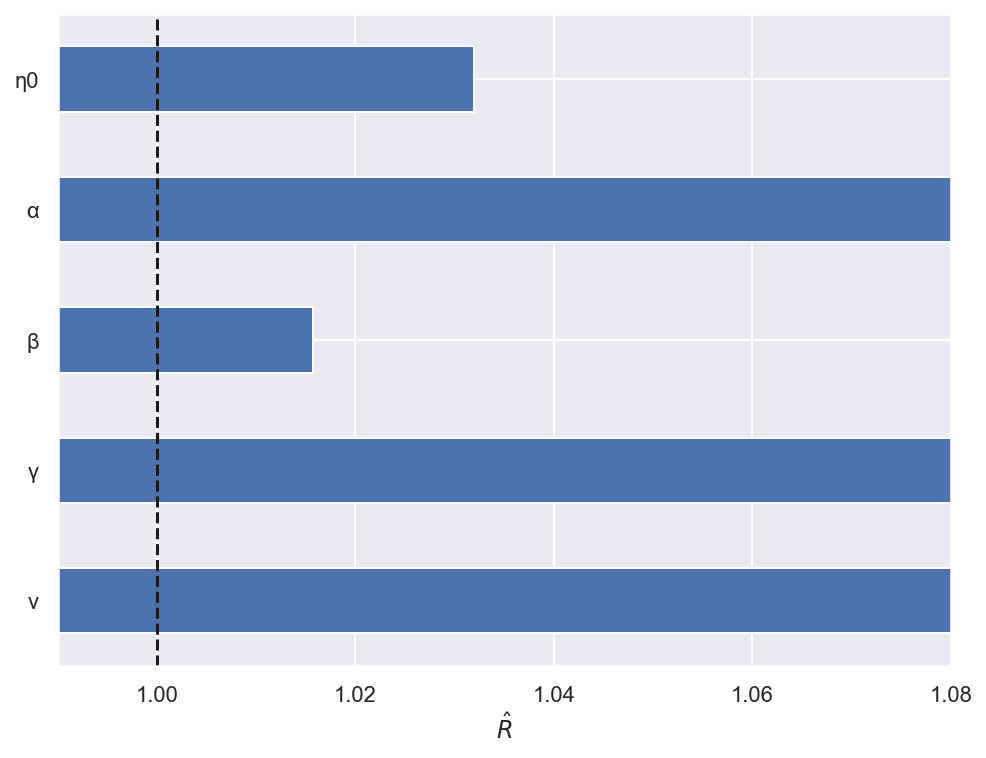

In [42]:
ax = (norm_rhat.max()
               .to_array()
               .to_series()
               .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.08);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

To demonstrate the impact of these elevated $\hat{R}$ statistics, we visualize the samples from the $\alpha_i$ component with the highest $\hat{R}$ statistic below.

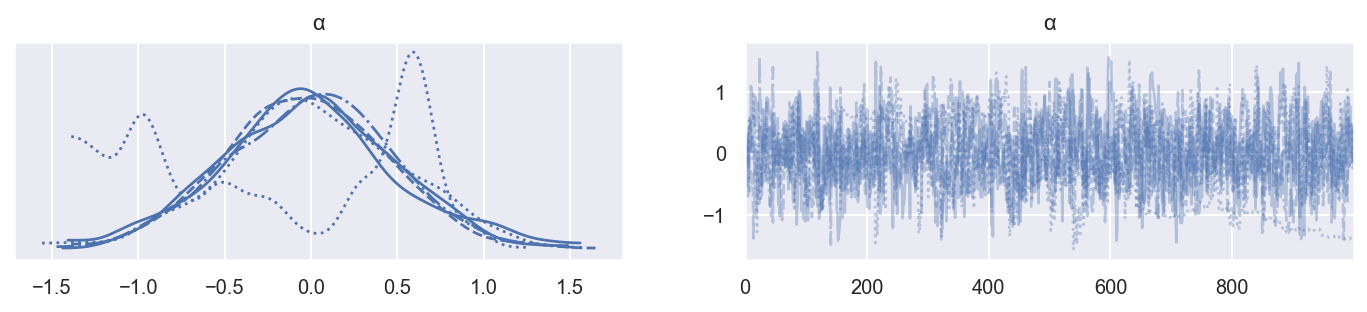

In [43]:
α_worst = norm_rhat["α"].idxmax()

az.plot_trace(norm_trace, var_names="α", coords={"age": α_worst}, divergences=False);

In the kernel density estimates on the left, we see at least one chain that is meandering around the parameter space.

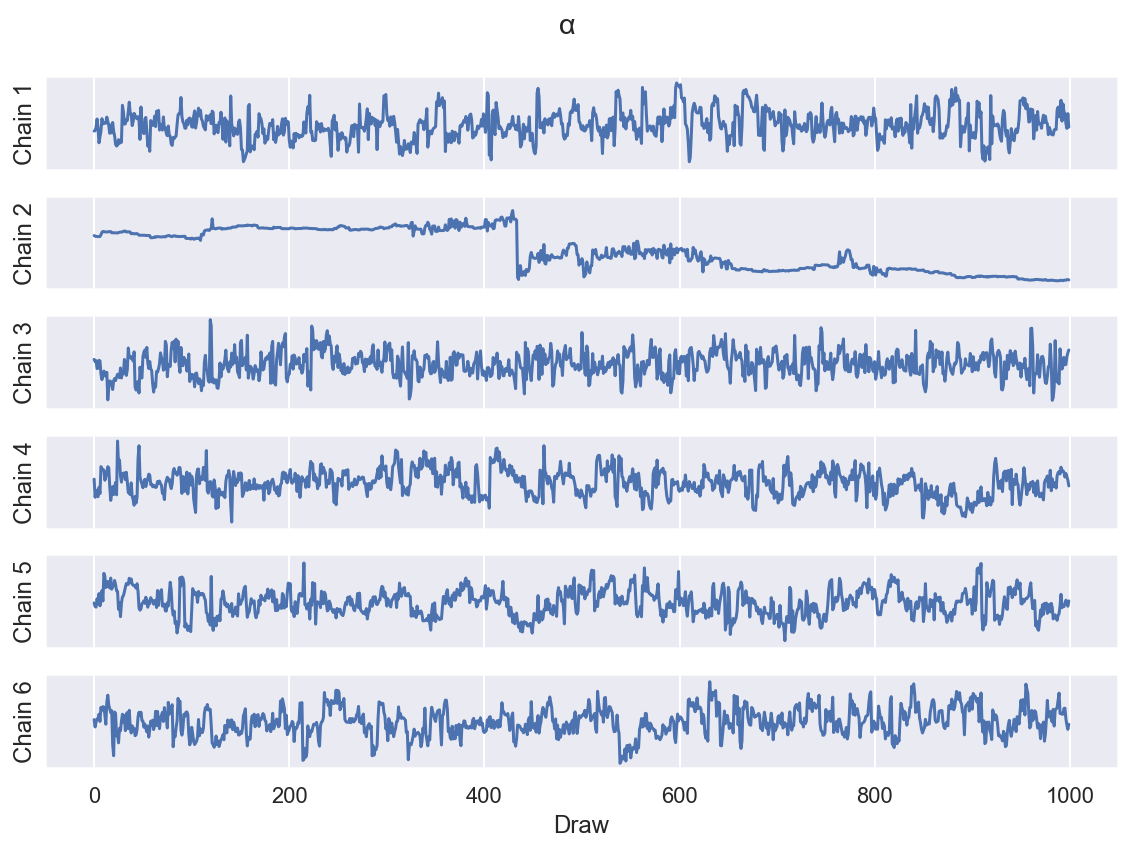

In [44]:
fig, axes = plt.subplots(nrows=CHAINS, sharex=True, sharey=True)

for chain, ax in enumerate(axes):
    (norm_trace.posterior["α"]
               .sel(age=α_worst, chain=chain)
               .plot(ax=ax));
    
    ax.set_xlabel(None);
    
    ax.set_yticks([]);
    ax.set_ylabel(f"Chain {chain + 1}");
    
    ax.set_title(None);

axes[-1].set_xlabel("Draw");

fig.suptitle("α");
fig.tight_layout();

Plotting each chain's trace on its own for clarity, we see that the second chain demonstrates particularly concerning behavior, producing relatively constant samples for long periods of time and then jumping to completely different portions of the parameter space.

Based on these results, we see that introducing regularization through normal priors has reduced but not eliminated the inference issues with this model.

### Noncentered normal priors

The APC model with normal priors shows that adding some regularization helps, so for our next model we increase the amount of regularization.  We do so by placing [hierarchical normal](https://www.bayesrulesbook.com/chapter-16.html#hierarchical-building-16) priors on the APC parameters,

$$\alpha_i \sim N(0, \sigma_{\alpha}^2),\ \sigma_{\alpha} \sim \operatorname{Half}-N(2.5^2),$$
$$\beta_i \sim N(0, \sigma_{\beta}^2),\ \sigma_{\beta} \sim \operatorname{Half}-N(2.5^2),$$
$$\gamma_i \sim N(0, \sigma_{\gamma}^2),\ \sigma_{\gamma} \sim \operatorname{Half}-N(2.5^2).$$

In reality, we use an equivalent [noncentered parameterization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) of this prior that often leads to more efficient sampling.

In [45]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [46]:
def noncentered_normal(name, *, dims):
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, Δ * σ, dims=dims)

In [47]:
with pm.Model(coords=coords, rng_seeder=SEED) as nc_model:
    η0 = pm.Normal("η0", 0, 2.5)

    α = noncentered_normal("α", dims="age")
    β = noncentered_normal("β", dims="year")
    γ = noncentered_normal("γ", dims="cohort")

The rest of the model is defined as before, with the addition of a [`MutableData`](https://docs.pymc.io/en/latest/api/generated/pymc.MutableData.html) container for the offset.  This container will be useful when we visualize the posterior predictive distribution.

In [48]:
with nc_model:
    η = η0 + α[i] + β[j] + γ[k]
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * at.exp(η), ν, observed=kids)

We now sample from the posterior distribution of this model.

In [49]:
with nc_model:
    nc_trace = pm.sample(target_accept=0.9, **SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, Δ_α, σ_α, Δ_β, σ_β, Δ_γ, σ_γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 50 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


No divergences occured during sampling, though we do see a low effective sample size warning.

In [50]:
nc_rhat = az.rhat(nc_trace)

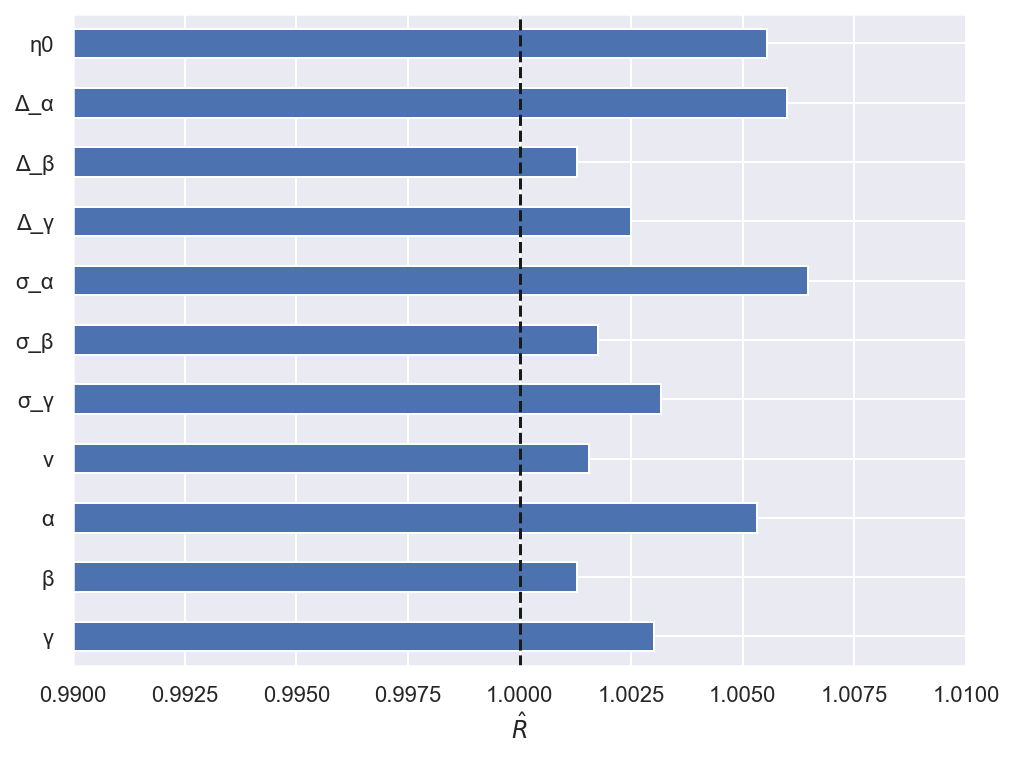

In [51]:
ax = (nc_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

The $\hat{R}$ statistics are comfortably below 1.01, a sign of significantly improved sampling.  The trace plot for the component of $\alpha$ with the highest $\hat{R}$ statistic also shows quite good mixing.

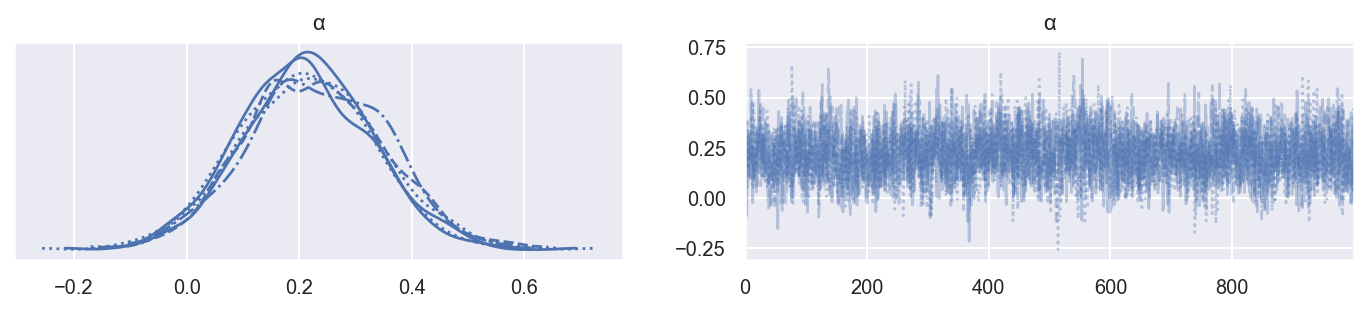

In [52]:
az.plot_trace(nc_trace, var_names="α", coords={"age": nc_rhat["α"].idxmax()}, divergences=False);

We now sample from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) of this model and visualize the results.

In [53]:
N_PP = 10_000 

def scale_pp(x):
    return x / N_PP

In [54]:
with nc_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    nc_trace.extend(pm.sample_posterior_predictive(nc_trace))

In [55]:
CI_WIDTH = 0.95

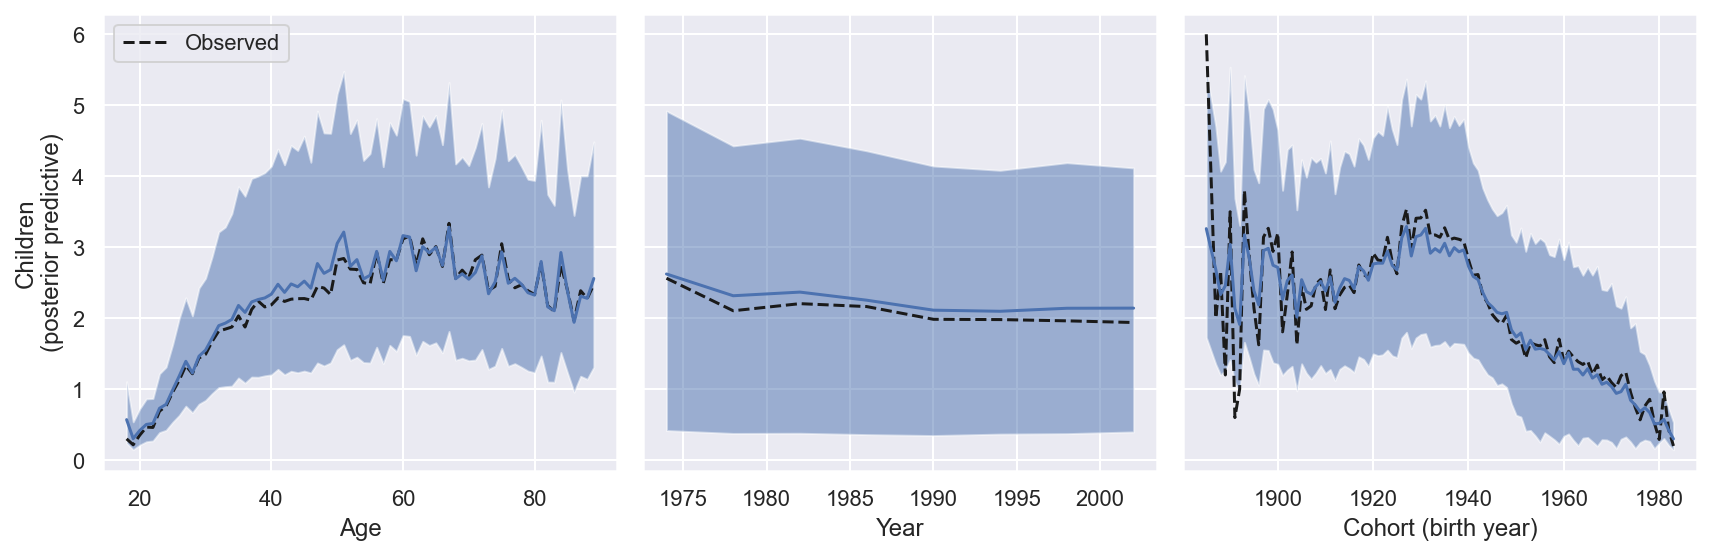

In [56]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

nc_pp_by_age = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[0].fill_between(age_map,
                     nc_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     nc_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5);
axes[0].plot(age_map, nc_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")));


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

nc_pp_by_year = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("year").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[1].fill_between(year_map,
                     nc_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     nc_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5);
axes[1].plot(year_map, nc_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")));

axes[1].set_xlabel("Year");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

nc_pp_by_cohort = (
    nc_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[2].fill_between(cohort_map,
                     nc_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     nc_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5);
axes[2].plot(cohort_map, nc_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")));


axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

Here we see solid agreement between the model and the observed data, perhaps even a bit too much agreement, as our APC effects seem to mimic the yearly noise in the observced data.  It would be reasonable to expect that the true APC effects are smoother than what we see here.  Our next two models how how including this behavior in our model can result in better sampling and more effective predictions.

### Noncentered normal random walk priors

We can incorporate the expectation that the number of children only changes a bit from year-to-year (and therefore the relationship is smoother than above) by a placing noncentered [Gaussian random walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) priors on $\alpha_i$, $\beta_j$, and $\gamma_k$.

In [57]:
def noncentered_normal_rw(name, *, dims):    
    innov = pm.Normal(f"innov_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    
    return pm.Deterministic(name, innov.cumsum() * σ, dims=dims)

In [58]:
with pm.Model(coords=coords, rng_seeder=SEED) as rw_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age")
    β = noncentered_normal_rw("β", dims="year")
    γ = noncentered_normal_rw("γ", dims="cohort")

The rest of the model is defined as before.

In [59]:
with rw_model:
    η = η0 + α[i] + β[j] + γ[k]
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * at.exp(η), ν, observed=kids)

We now sample from the posterior distribution of this model.

In [60]:
with rw_model:
    rw_trace = pm.sample(target_accept=0.95, **SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, innov_α, σ_α, innov_β, σ_β, innov_γ, σ_γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 277 seconds.


There are no divergences, no $\hat{R}$ warnings, and no effective sample size warnings.

In [61]:
rw_rhat = az.rhat(rw_trace)

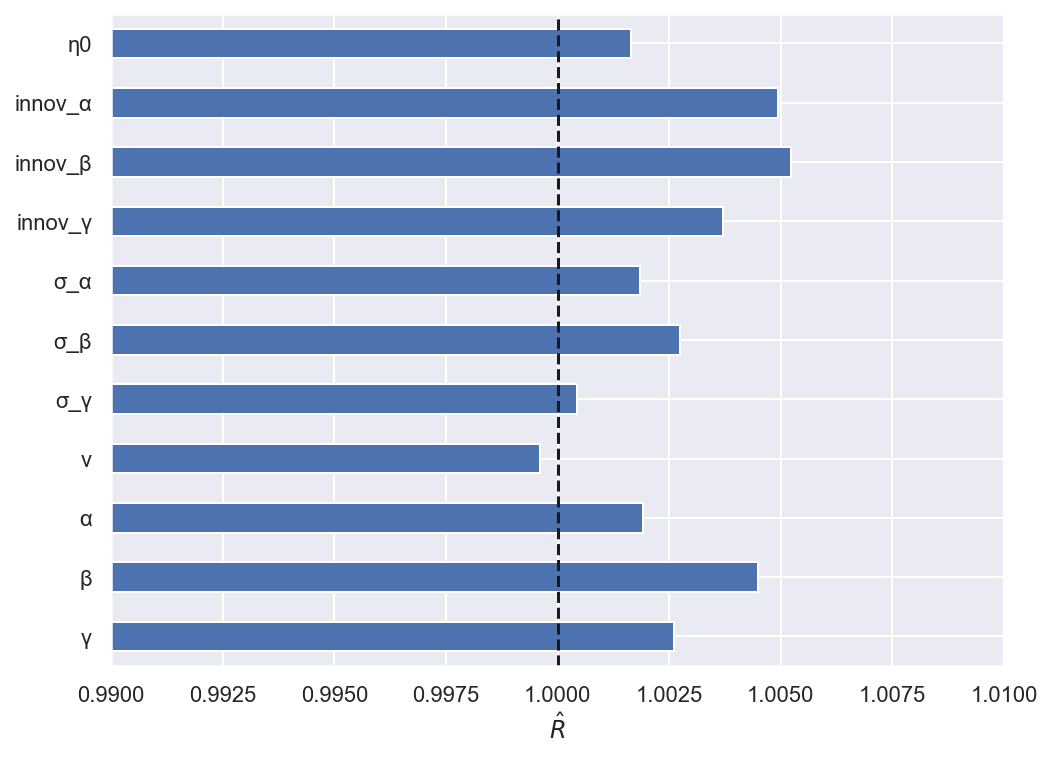

In [62]:
ax = (rw_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

We now sample from and visualize the posterior predictive distribution.

In [63]:
with rw_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    rw_trace.extend(pm.sample_posterior_predictive(rw_trace))

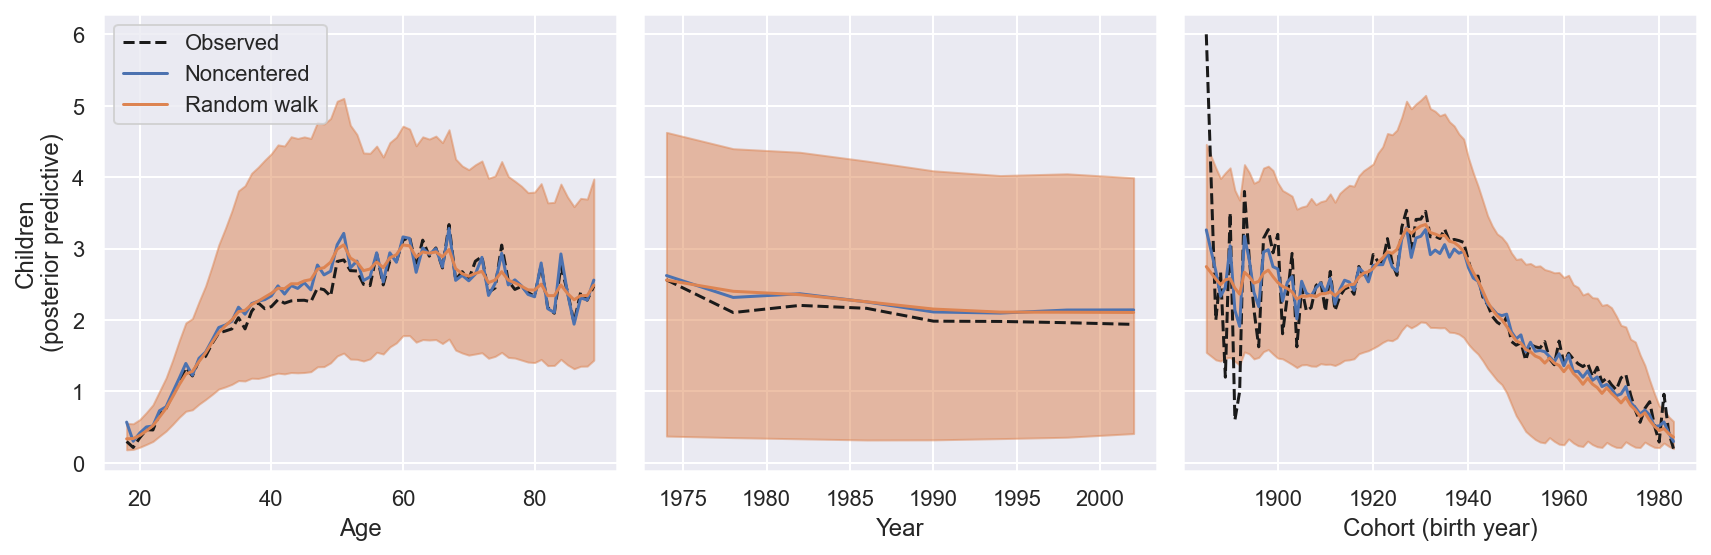

In [64]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

rw_pp_by_age = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[0].fill_between(age_map,
                     rw_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     rw_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C1");
axes[0].plot(age_map, nc_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             label="Noncentered");
axes[0].plot(age_map, rw_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1", label="Random walk");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

rw_pp_by_year = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("year").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[1].fill_between(year_map,
                     rw_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     rw_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C1");
axes[1].plot(year_map, nc_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")));
axes[1].plot(year_map, rw_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1");

axes[1].set_xlabel("Year");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

rw_pp_by_cohort = (
    rw_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[2].fill_between(cohort_map,
                     rw_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     rw_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C1");
axes[2].plot(cohort_map, nc_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")));
axes[2].plot(cohort_map, rw_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1");

axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

We see that the posterior predictive mean for the random walk model is considerably smoother year-over-year than that of the noncentered normal model; this smoothness is particularly evident in the cohort plot.

We use  [Pareto-smoothed importance sampling leave-one-out cross validation](https://arxiv.org/abs/1507.04544) (PSIS-LOO) to quantify the extent to which the random walk model is an improvement over the noncentered normal model.

In [65]:
traces = {
    "Noncentered": nc_trace,
    "Random walk": rw_trace
}

In [66]:
comp_df = pm.compare(traces)

In [67]:
comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Random walk,0,-1903.937438,29.843949,0.000000,1.0,16.355066,0.00000,False,log
Noncentered,1,-1962.129697,74.518856,58.192259,0.0,16.478794,5.32143,False,log


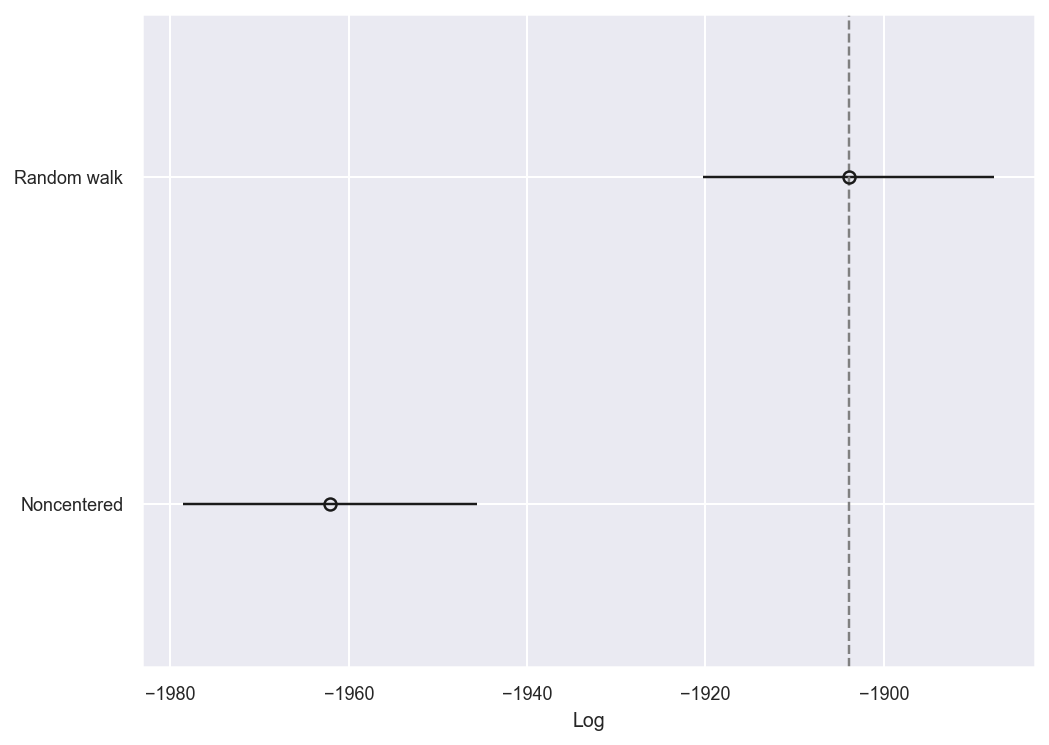

In [68]:
fig, ax = plt.subplots()

az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);

We see that the random walk model is not just a visual improvement over the noncentered normal model, but shows an appreciable quantitative improvement in predictive accuracy (as judged by PSIS-LOO).

It is particularly gratifying to see a model that better encodes our intuitions about the smoothness of APC effects perform better both from a computational and predictive perspective.

### Smoothing splines

[Smoothing splines](https://en.wikipedia.org/wiki/B-spline) are an even more powerful way to encode smoothness assumptions into our APC model which we will now compare to the noncentered normal random walk model.  We will not include a full introduction to smoothing splines (or their Bayesian treatment) here, but we follow [Milad Kharratzadeh’s](http://www.miladkh.com/) excellent short paper [_Splines in Stan_](https://github.com/milkha/Splines_in_Stan/blob/master/splines_in_stan.pdf).  For more details about splines see two previous posts, [Bayesian Splines with Heteroskedastic Noise in Python with PyMC3
](https://austinrochford.com/posts/2021-08-11-splines-hetero.html) and [Fitting a Simple Additive Model in Python
](https://austinrochford.com/posts/2015-08-29-additive.html).

We only use smoothing splines to model the age and cohort effects here, since they have many more observed values than the period (`year`) in which the survey was conducted.

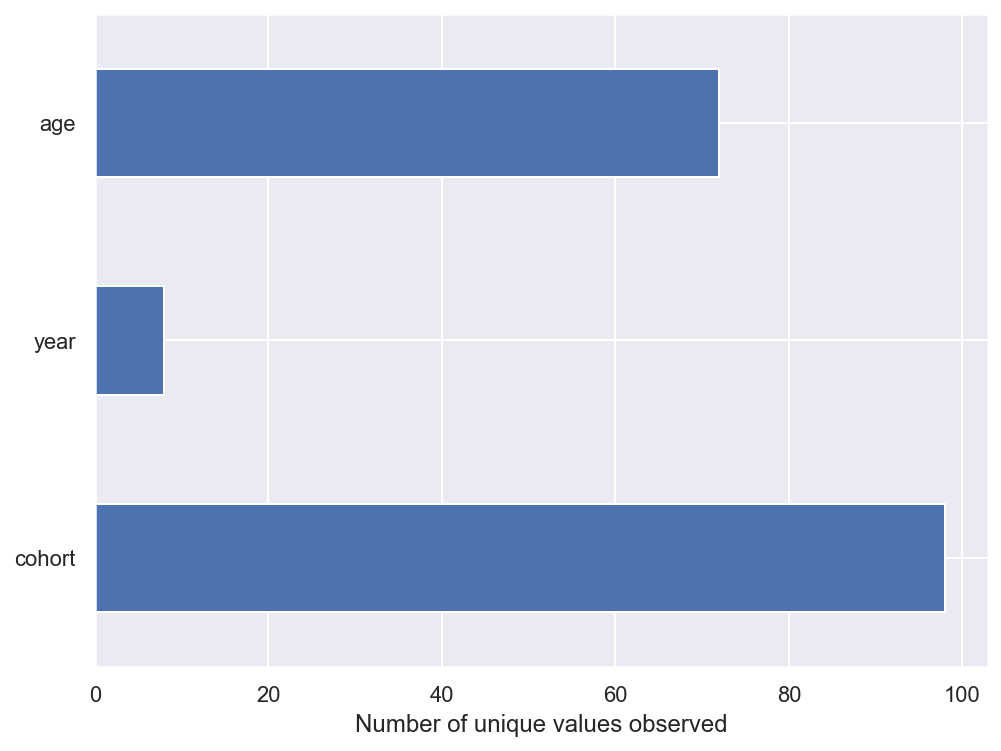

In [69]:
ax = (df[["age", "year", "cohort"]]
         .nunique()
         .plot(kind="barh"))

ax.set_xlabel("Number of unique values observed");
ax.invert_yaxis();

We define ten knots each for age and cohort, and use `scipy` to form the cubic B-spline [design matrix](https://en.wikipedia.org/wiki/Design_matrix).

In [70]:
N_KNOT = 10

In [71]:
age_knots = np.linspace(15, 96, N_KNOT)
age_dmat = sp.interpolate.BSpline(age_knots, np.eye(N_KNOT), 3)(
    apc_df.index.get_level_values("age").values
)

In [72]:
cohort_knots = np.linspace(1885, 1986, N_KNOT)
cohort_dmat = sp.interpolate.BSpline(cohort_knots, np.eye(N_KNOT), 3)(
    apc_df.index.get_level_values("cohort").values
)

The spline model uses different coordinates than the previous models.

In [73]:
spline_coords = {
    "age_knot": np.arange(N_KNOT),
    "year": year_map,
    "cohort_knot": np.arange(N_KNOT)
}

We use the priors on the spline coefficients $\alpha_i$ and $\gamma_k$ suggested in [_Splines in Stan_](https://github.com/milkha/Splines_in_Stan/blob/master/splines_in_stan.pdf) (rescaled for computational efficiency).

In [74]:
with pm.Model(coords=spline_coords, rng_seeder=SEED) as spline_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age_knot") / np.sqrt(N_KNOT)
    β = noncentered_normal_rw("β", dims="year")
    γ = noncentered_normal_rw("γ", dims="cohort_knot") / np.sqrt(N_KNOT)

The rest of the model is defined the similarly to before.

In [75]:
with spline_model:
    η = η0 + at.dot(age_dmat, α) + β[j] + at.dot(cohort_dmat, γ)
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * at.exp(η), ν, observed=kids)

We now sample from the posterior distribution of this model.

In [76]:
with spline_model:
    spline_trace = pm.sample(target_accept=0.99, **SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, innov_α, σ_α, innov_β, σ_β, innov_γ, σ_γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 462 seconds.


There are no divergences, no $\hat{R}$ warnings, and no effective sample size warnings.

In [77]:
spline_rhat = az.rhat(spline_trace)

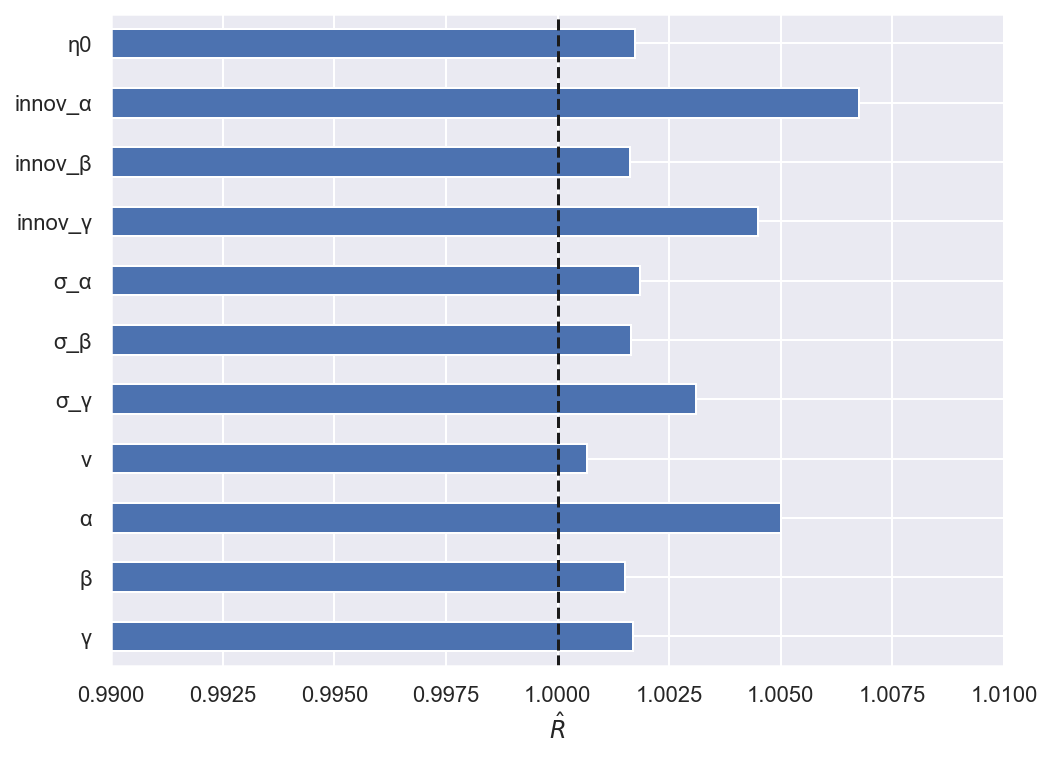

In [78]:
ax = (spline_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

We now sample from and visualize the posterior predictive distribution.

In [79]:
with spline_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    spline_trace.extend(pm.sample_posterior_predictive(spline_trace))

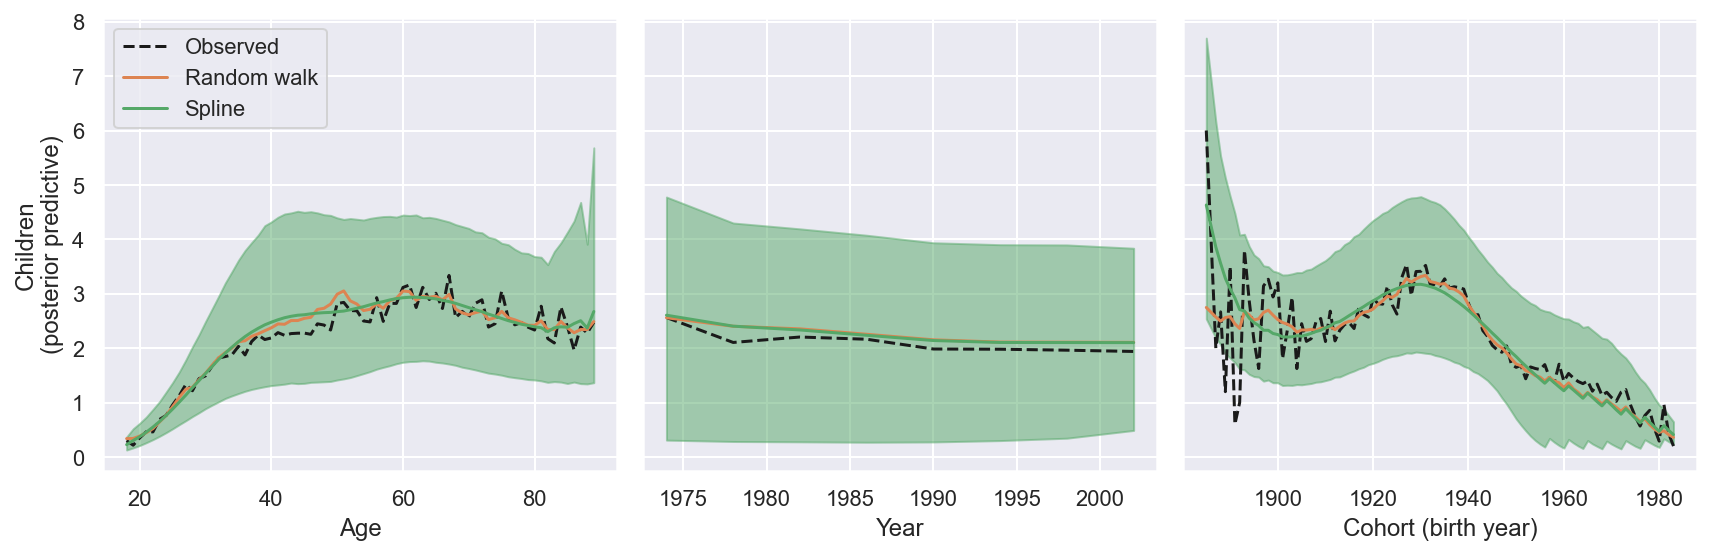

In [80]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))

# age

(df.groupby("age")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=axes[0]))

spline_pp_by_age = (
    spline_trace.posterior_predictive
                .assign_coords(kids_dim_0=apc_df.index.get_level_values("age").values)
                ["kids"]
                .pipe(scale_pp)
                .groupby("kids_dim_0")
)

axes[0].fill_between(age_map,
                     spline_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     spline_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C2");
axes[0].plot(age_map, rw_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1", label="Random walk");
axes[0].plot(age_map, spline_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2", label="Spline");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# year

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

spline_pp_by_year = (
    spline_trace.posterior_predictive
                .assign_coords(kids_dim_0=apc_df.index.get_level_values("year").values)
                ["kids"]
                .pipe(scale_pp)
                .groupby("kids_dim_0")
)

axes[1].fill_between(year_map,
                     spline_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     spline_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C2");
axes[1].plot(year_map, rw_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1");
axes[1].plot(year_map, spline_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2");

axes[1].set_xlabel("Year");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[2]));

spline_pp_by_cohort = (
    spline_trace.posterior_predictive
                .assign_coords(kids_dim_0=apc_df.index.get_level_values("cohort").values)
                ["kids"]
                .pipe(scale_pp)
                .groupby("kids_dim_0")
)

axes[2].fill_between(cohort_map,
                     spline_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     spline_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C2");
axes[2].plot(cohort_map, rw_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C1");
axes[2].plot(cohort_map, spline_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2");

axes[2].set_xlabel("Cohort (birth year)");

fig.tight_layout();

We see that the posterior predictive mean for the spline model is considerably smoother year-over-year than that of the noncentered normal random walk model model; this smoothness is particularly evident in the cohort plot.

We compare this model with the two previous ones.

In [81]:
traces["Spline"] = spline_trace

In [82]:
comp_df = pm.compare(traces)

In [83]:
comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Spline,0,-1900.014235,9.728448,0.000000,0.657634,16.891238,0.000000,False,log
Random walk,1,-1903.937438,29.843949,3.923203,0.342366,16.355066,5.064813,False,log
Noncentered,2,-1962.129697,74.518856,62.115462,0.000000,16.478794,7.580858,False,log


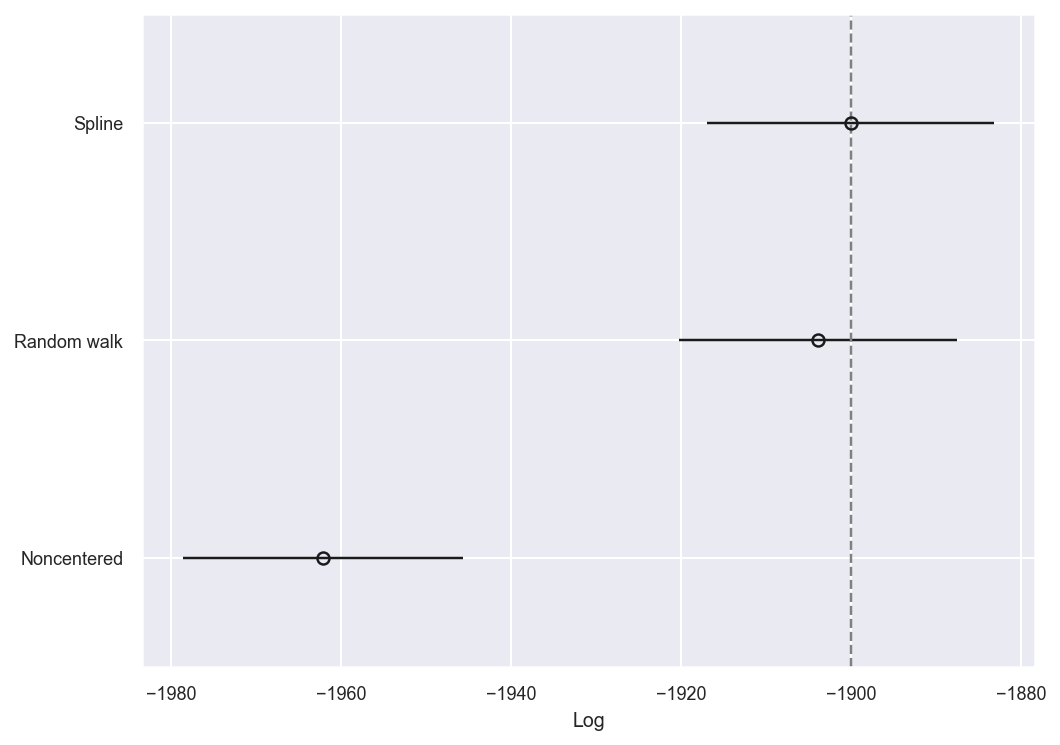

In [84]:
fig, ax = plt.subplots()

az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);

We see that the spline model is a slight improvement over the noncentered normal random walk model from the perspective of PSIS-LOO.

#### Age/cohort submodel

With these five models we have iterated from an unidentified model, to models that were less degenerate but still sampled poorly, to smoothly varying models that sample well.  Having overcome these issues with our initial models, we now turn to the question of whether including a period (year) effect is actually beneficial.

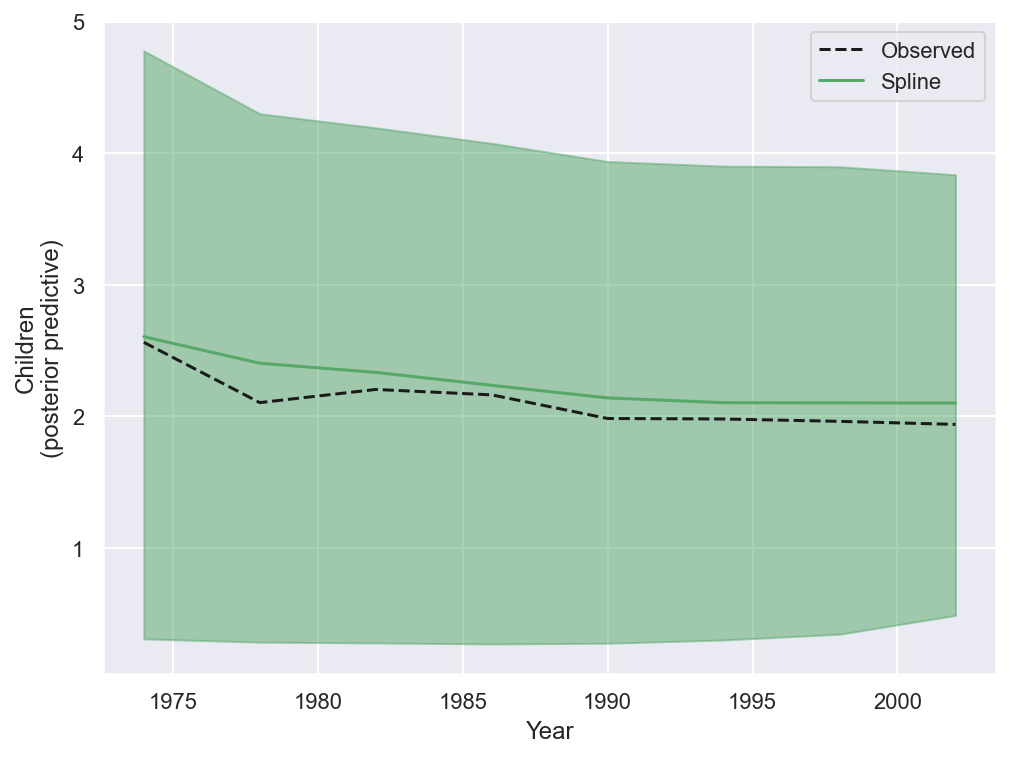

In [85]:
fig, ax = plt.subplots()

(df.groupby("year")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", label="Observed", ax=ax));

ax.fill_between(year_map,
                spline_pp_by_year.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                spline_pp_by_year.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                alpha=0.5, color="C2");
ax.plot(year_map, spline_pp_by_year.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2", label="Spline");

ax.set_xlabel("Year");
ax.set_ylabel("Children\n(posterior predictive)");
ax.legend();

The posterior predictive effect of period on the number of children from the previous model appears to be rather flat, giving us reason to suspect that it may not contribut much to the model's predictive accuracy.  We now quantify the impact of removing period effects on the predictive accuracy of our model.

For $\alpha_i$ and $\gamma_k$, we use the same priors as the APC spline model, but we set $\beta_k \equiv 0$.

In [86]:
with pm.Model(coords=spline_coords, rng_seeder=SEED) as ac_model:
    η0 = pm.Normal("η0", 0, 2.5)
    
    α = noncentered_normal_rw("α", dims="age_knot") / np.sqrt(age_knots.size)
    γ = noncentered_normal_rw("γ", dims="cohort_knot") / np.sqrt(cohort_knots.size)
    
    η = η0 + at.dot(age_dmat, α) + at.dot(cohort_dmat, γ)
    
    N_ = pm.MutableData("N", N)
    ν = pm.HalfNormal("ν", 2.5)
    pm.NegativeBinomial("kids", N_ * at.exp(η), ν, observed=kids)

We now sample from the posterior distribution of this model.

In [87]:
with ac_model:
    ac_trace = pm.sample(target_accept=0.99, **SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [η0, innov_α, σ_α, innov_γ, σ_γ, ν]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 369 seconds.


There are no divergences, no $\hat{R}$ warnings, and no effective sample size warnings.

In [88]:
ac_rhat = az.rhat(ac_trace)

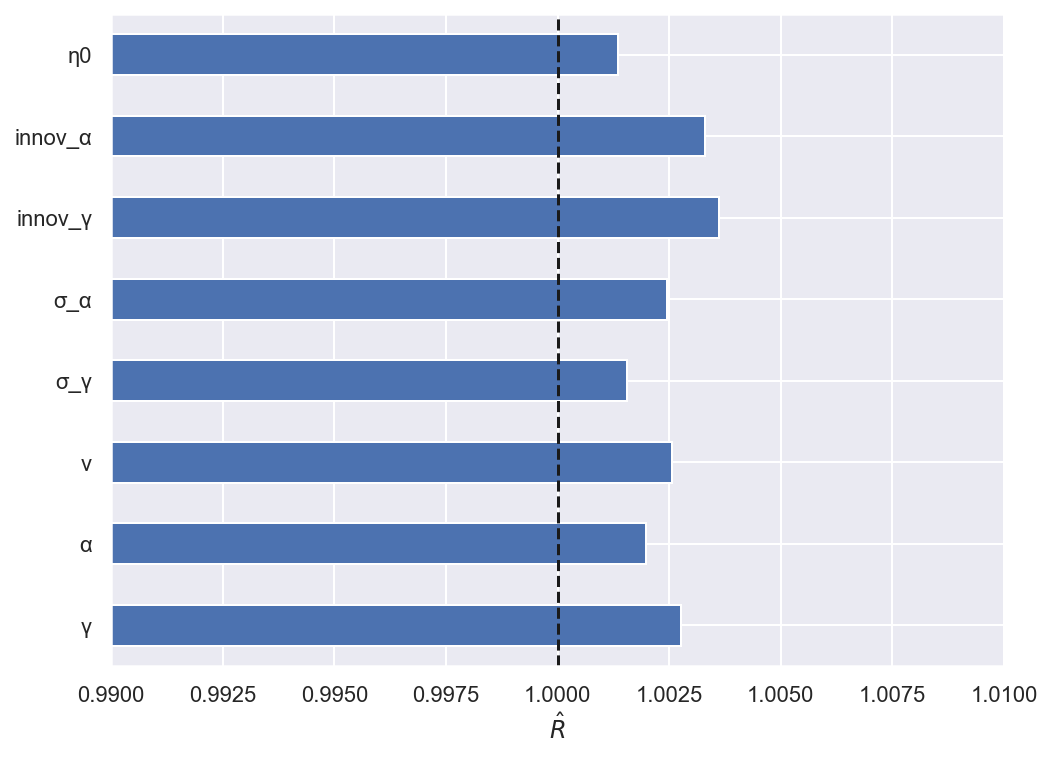

In [89]:
ax = (ac_rhat.max()
             .to_array()
             .to_series()
             .plot(kind="barh"))
ax.axvline(1, c="k", ls="--");

ax.set_xlim(0.99, 1.01);
ax.set_xlabel(r"$\hat{R}$");

ax.invert_yaxis();
ax.set_ylabel(None);

We now sample from and visualize the posterior predictive distribution.

In [90]:
with ac_model:
    pm.set_data({"N": np.full_like(N, N_PP)})
    ac_trace.extend(pm.sample_posterior_predictive(ac_trace))

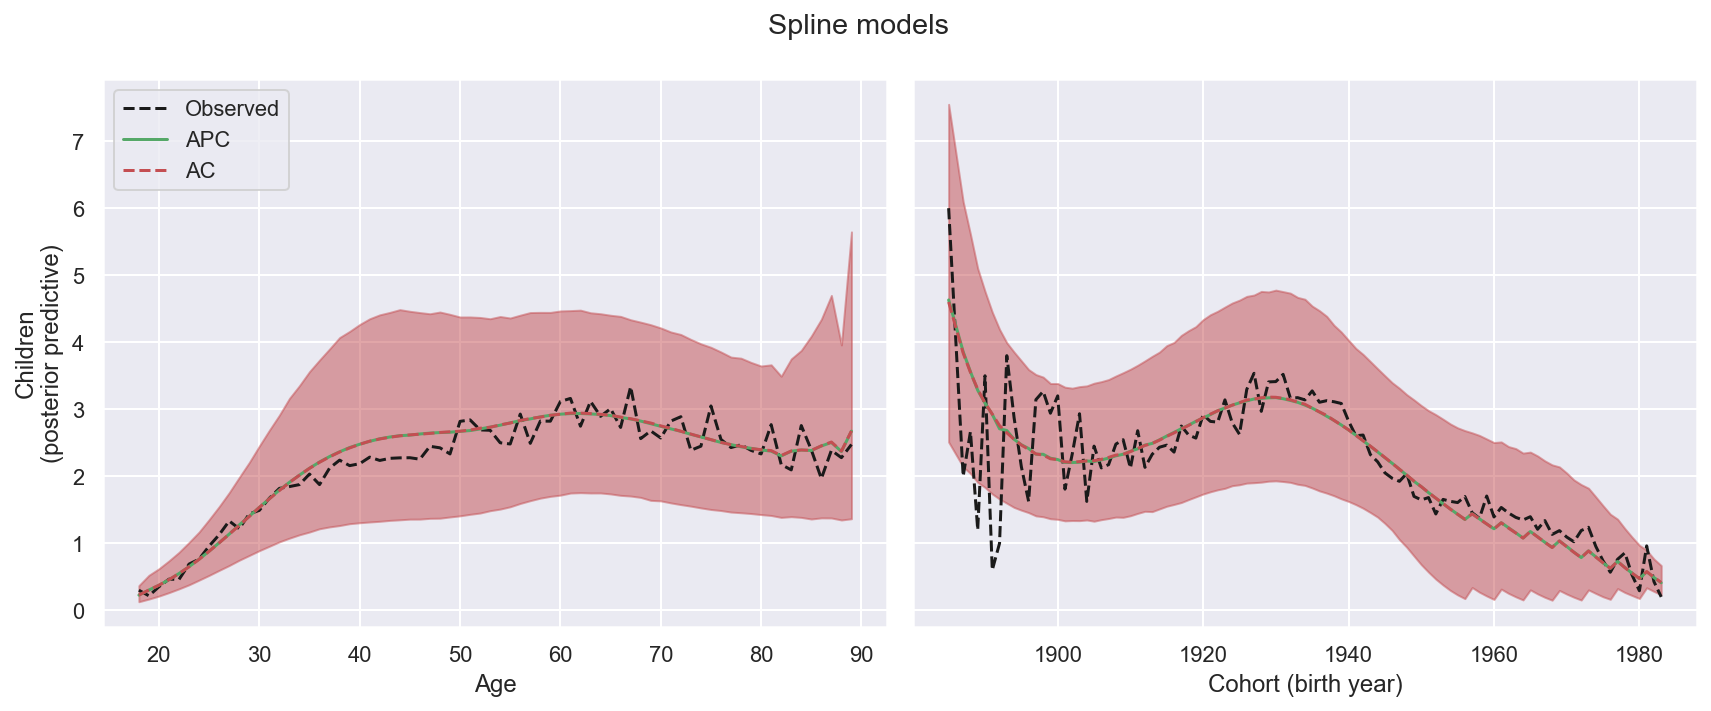

In [91]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

# age

(df.groupby("age")
   ["kids"]
   .mean()
   .plot(c="k", ls="--", label="Observed", ax=axes[0]))

ac_pp_by_age = (
    ac_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("age").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[0].fill_between(age_map,
                     ac_pp_by_age.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     ac_pp_by_age.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C3");
axes[0].plot(age_map, spline_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2", label="APC");
axes[0].plot(age_map, ac_pp_by_age.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C3", ls="--", label="AC");


axes[0].set_xlabel("Age");
axes[0].set_ylabel("Children\n(posterior predictive)");

axes[0].legend(loc="upper left");

# cohort

(df.groupby("cohort")
        ["kids"]
        .mean()
        .plot(c="k", ls="--", ax=axes[1]));

ac_pp_by_cohort = (
    ac_trace.posterior_predictive
            .assign_coords(kids_dim_0=apc_df.index.get_level_values("cohort").values)
            ["kids"]
            .pipe(scale_pp)
            .groupby("kids_dim_0")
)

axes[1].fill_between(cohort_map,
                     ac_pp_by_cohort.quantile((1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     ac_pp_by_cohort.quantile(1 - (1 - CI_WIDTH) / 2, dim=("chain", "draw", "kids_dim_0")),
                     alpha=0.5, color="C3");
axes[1].plot(cohort_map, spline_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C2");
axes[1].plot(cohort_map, ac_pp_by_cohort.mean(dim=("chain", "draw", "kids_dim_0")),
             c="C3", ls="--");

axes[1].set_xlabel("Cohort (birth year)");

fig.suptitle("Spline models");
fig.tight_layout();

We see that the posterior predictions from the APC and AC spline models are visually indistinguishable.

In [92]:
spline_traces = {
    "APC": spline_trace,
    "AC": ac_trace
}

In [93]:
spline_comp_df = pm.compare(spline_traces)

In [94]:
spline_comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
APC,0,-1900.014235,9.728448,0.000000,1.0,16.891238,0.000000,False,log
AC,1,-1900.521989,8.158803,0.507754,0.0,16.921409,0.913015,False,log


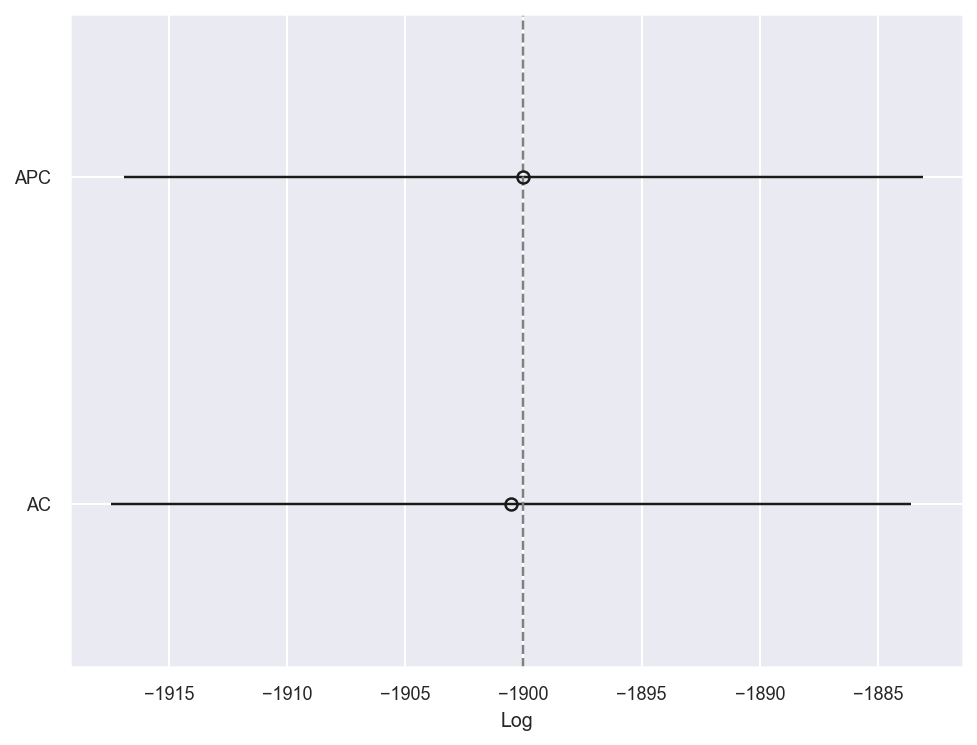

In [95]:
fig, ax = plt.subplots()

az.plot_compare(spline_comp_df, insample_dev=False, plot_ic_diff=False,
                textsize=9, ax=ax);

Comparing the APC and AC spline models using PSIS-LOO shows that they are practically indistinguishable, so we prefer the more parismonious AC model.  (Models that omit period have the added advantage that they are easier to use in forecasting as we need not hypothesize a specific functional form for future period effects.)

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/103cf7ad47e391f004111c745cfbbcc8).

In [96]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Mon Aug 22 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

scipy     : 1.8.0
numpy     : 1.22.2
seaborn   : 0.11.2
aesara    : 2.5.1
arviz     : 0.12.1
pymc      : 4.0.0b6
pandas    : 1.4.1
matplotlib: 3.5.1

